In [222]:
import sys
# !{sys.executable} -m pip install seaborn
import itertools
import numpy as np
# import spotipy
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import spotipy
import spotipy.util
from collections import defaultdict
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
%matplotlib inline

# Create your own Spotify app to get the ID and secret.
# https://beta.developer.spotify.com/dashboard/applications
CLIENT_ID = '06fdc33f688440e6bff40f6eb930f21c'
CLIENT_SECRET = 'f83c328423054a73a3daa9ae9045e538'

# Put your Spotify username here.
USERNAME = 'james.hoke.peacock'

REDIRECT_URI = 'http://localhost/'
SCOPE = 'user-library-read playlist-modify-public playlist-modify-private'

# Create a Spotify client that can access my saved song information.
token = spotipy.util.prompt_for_user_token(USERNAME,
                                           SCOPE,
                                           client_id=CLIENT_ID,
                                           client_secret=CLIENT_SECRET,
                                           redirect_uri=REDIRECT_URI)


# token_info = ouath2.

sp = spotipy.Spotify(auth=token)
# Function that returns the next n elements from the iterator. Used because
# Spotify limits how many items you can group into each of its API calls.
def grouper(n, iterable):
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk
        
# TURN THIS INTO A kmeans training program/evaluation 
# for n playlist uris. It self evaluates how well it can categorize songs 
# into their correct playlist. And it visualizes its learning too
COLORS = ['skyblue', 'orange', 'red']
def build_dataset(playlist_uris):
    uris = set([])
    expected = {} #d efaultdict(list) # if songs are on multiple plists
    color = {}
    clr = 0
    cs = []
    for p in playlist_uris:
        plid = p.split(":")[-1]
        plist =  sp._get("playlists/%s" % (plid))
        track_results = sp._get("playlists/%s/tracks" % (plid), limit=100, offset=0,market='US')
        tracks_on_plist = [track[u'track'][u'uri'] for track in track_results['items']]
        for t in tracks_on_plist:
            expected[t] = plist['name']
            color[t] = COLORS[clr]
        uris = uris.union(set(tracks_on_plist))
        clr += 1
        cs.append(plist['name'])
    # Get the audio features of each of the URIs fetched above.
    uris_to_features = {}
    for group in grouper(50, uris):
        res = sp.audio_features(tracks=group)
        for item in res:
            uris_to_features[item['uri']] = item
        
    return uris_to_features, expected, color, cs


def search_my_playlists(name):
    plists = sp.current_user_playlists()['items']
    for plist in plists:
        if plist['name'] == name:
            print(plist)
            playlist_id = plist['id']
            break

    results = sp.user_playlist(username, playlist_id)['tracks']
    add_uris(results)
    while ('next' in results.keys() and results['next']):
        results = sp.next(results)
        add_uris(results)


FEATURE_VECTOR = [
#     'acousticness',
    'danceability',
#     'duration_ms',
    'energy',
#     'instrumentalness',
#     'key',
#     'liveness',
#     'loudness',
#     'mode',
#     'speechiness',
    'tempo',
#     'time_signature',
#     'valence'
]

def features_to_vector(item):
    return np.array([item[key] for key in FEATURE_VECTOR])

house_home_uri = 'spotify:user:heathrfeathr:playlist:3xwAMNQ6hHChEkG8469Iy1' # deep techno
this_is_tim_uri = 'spotify:user:spotify:playlist:37i9dQZF1DX1PQl5Hsjdb8' # country
this_is_metallica_uri = 'spotify:user:spotify:playlist:37i9dQZF1DXbj9Ksq4BAdj' # rock
african_heat_uri = 'spotify:user:spotify:playlist:37i9dQZF1DWYkaDif7Ztbp' # afro

In [224]:
rap_caviar_uri = 'spotify:user:spotify:playlist:37i9dQZF1DX0XUsuxWHRQd' # rap/hip/hop
indie_uri = 'spotify:user:spotify:playlist:37i9dQZF1DXdbXrPNafg9d'

### LIST HERE
uris_to_features, expected, colors, cs = build_dataset([indie_uri, this_is_metallica_uri, african_heat_uri])

In [225]:
vectors = [(x[0], features_to_vector(x[1])) for x in uris_to_features.items()]
viz_vectors = [np.concatenate((features_to_vector(x[1]), [expected[x[0]]], [colors[x[0]]])) for x in uris_to_features.items()]

In [226]:
def viz_clusters(df, c):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = df['color'] #if 'color' in df else 'skyblue'
        
    ax.scatter(df[c[0]], df[c[1]], df[c[2]], c=colors, s=60)
    ax.view_init(30, 185)
    plt.show()

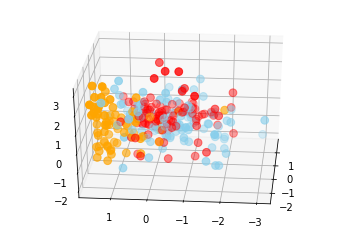

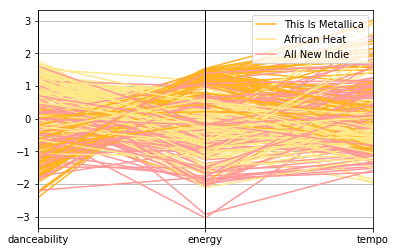

In [227]:
def viz_dataset(song_dataframe, cols):
    subset_df = song_dataframe[cols]

    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()

    scaled_df = ss.fit_transform(subset_df)
    scaled_df = pd.DataFrame(scaled_df, columns=cols)
    scaled_df = pd.concat([scaled_df, song_dataframe['plist_name']], axis=1)
    final_df = pd.concat([scaled_df, song_dataframe['color']], axis=1)
    final_df.head()

    viz_clusters(final_df, cols)
    # plot parallel coordinates
    from pandas.plotting import parallel_coordinates
    pc = parallel_coordinates(final_df[cols+['plist_name']], 'plist_name', color=('#FFB222','#FFE888', '#FF9999'))

ALL_COLS = FEATURE_VECTOR + ['plist_name'] + ['color']
songs_dataframe = pd.DataFrame(data=viz_vectors,columns=ALL_COLS)
indexed = songs_dataframe.reindex(columns=ALL_COLS)
# print(indexed)
viz_dataset(indexed, FEATURE_VECTOR)

In [228]:
import sklearn.preprocessing

# Gets an X-matrix given data as 2-element tuples with IDs and vectors.
def get_x(values):
    return np.vstack([x[1] for x in values])

# Given an object with a .transform(), apply it to the data vectors.
def apply_transform(transformer, data):
    return [(x[0], transformer.transform(x[1].reshape(1, -1))) for x in data]

def train_and_apply(transformer, data):
    X = get_x(data)
    transformer.fit(X)
    return apply_transform(transformer, data)

scaled = train_and_apply(sklearn.preprocessing.StandardScaler(), vectors)

In [229]:
import sklearn.cluster
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


RUN_ON = scaled

# distortions = []
# K = range(1,10)
# X = get_x(RUN_ON)
# for k in K:
#     kmeanModel = sklearn.cluster.KMeans(n_clusters=k, n_jobs=-1).fit(X)
#     kmeanModel.fit(X)
#     distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

NUM_CLUSTERS=3
model = sklearn.cluster.KMeans(n_clusters=NUM_CLUSTERS,
                               n_jobs=-1)
model.fit(get_x(RUN_ON))
classified = [(x[0], model.predict(x[1])[0]) for x in RUN_ON]

In [230]:
# print(expected)
# print(classified)
correct = 0
# cs = ['This Is Metallica', 'African Heat', 'All New Indie']
print(cs)

missed = []
for i in classified:
    if expected[i[0]] == cs[i[1]]:
        correct += 1
    else:
#         print("Expected: %s - Classified: %s | %s" %(expected[i[0]], cs[i[1]], i[0]))
        missed.append(i[0])
print("%i correct out of %i" % (correct, len(classified)))
# for m in missed[:20]:
#     print(sp.track(m)['name'])

[u'All New Indie', u'This Is Metallica', u'African Heat']
116 correct out of 272


In [177]:
print(model.cluster_centers_)

[[-0.81230034  0.63344489 -0.4747727 ]
 [ 0.74009587 -0.57713868  0.43257069]]


In [ ]:
# # Now convert the classified songs into some playlists.
# ids = []
# for cluster in range(NUM_CLUSTERS):
#     playlist_id = sp.user_playlist_create(USERNAME,
#                                           PLAYLIST_NAME_FMT.format(VERSION, cluster))['id']
#     ids.append(playlist_id)

# def get_all_classified_as(classified, item_class):
#     return [x[0] for x in classified if x[1] == item_class]

# for cluster in range(NUM_CLUSTERS):
#     tracks = get_all_classified_as(classified, cluster)
#     playlist = ids[cluster]
#     for group in grouper(100, tracks):
#         sp.user_playlist_add_tracks(USERNAME, playlist, group)

In [ ]:
sp.r